In [1]:
import keras
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
plt.style.use('ggplot') ## Usando el estilo de gráficos de ggplot
%matplotlib inline

Using TensorFlow backend.


In [2]:
from numpy.random import seed 
from tensorflow import set_random_seed
rs = 2018 ##Definiendo las semillas para la replicar resultados
np.random.seed(rs)
set_random_seed(rs)

## Spliting
Genrando la partición de la muestra de entranamiento y de evaluación

In [3]:
Total = pd.read_csv("DataSetMatrix.csv", sep=";") # importando

In [4]:
Total.shape # tamaño del dataset

(101, 14246)

In [5]:
Total = Total.iloc[:,1:] #eliminando primera columna
y = Total.loc[:,"Clasificador"] # Extrayendo clases
Total.drop(columns="Clasificador", axis=0, inplace=True) #Eliminando y de la matriz de entrada
Total.shape

(101, 14244)

# Realizando la segmentación TF-IDF
Podemos observar la matriz de TF con la matriz de conteo de frecuencias absolutas 

Hallando el TF-IDF 
$$TF - IDF(t,d) = tf(t,d)\ x\ idf(t) $$

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer #importando TD IDF de sklearn
transformer = TfidfTransformer(smooth_idf=False) ##seteandola en la función transformer
transformer   

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [7]:
tfidf = transformer.fit_transform(Total.values) # aplicando la funcion Tf Idf al data set 
tfidf 
X = tfidf.toarray()

In [8]:
X

array([[0.00286206, 0.01402434, 0.00272162, ..., 0.00544323, 0.00849986,
        0.01133315],
       [0.00573434, 0.01123951, 0.00272648, ..., 0.01363238, 0.0056767 ,
        0.        ],
       [0.00283647, 0.01111916, 0.00539457, ..., 0.00809185, 0.01403979,
        0.00561591],
       ...,
       [0.00566568, 0.00277624, 0.00538767, ..., 0.        , 0.01121747,
        0.        ],
       [0.00571668, 0.0112049 , 0.01359041, ..., 0.01359041, 0.01414804,
        0.00565922],
       [0.01137007, 0.00278572, 0.00270304, ..., 0.00540607, 0.01125578,
        0.00281394]])

In [9]:
## Separando las muestras de entrenamiento y de control 
np.random.seed(rs)
set_random_seed(rs)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,random_state=rs) # Semilla = random_state 

In [10]:
X_train.shape

(80, 14244)

In [11]:
X_test.shape

(21, 14244)

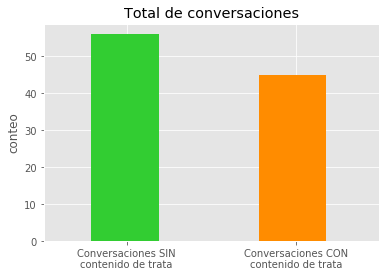

In [12]:
fig , ax = plt.subplots(1) #Distribucion total
cv, cm = ax.bar(("Conversaciones SIN\ncontenido de trata", "Conversaciones CON\ncontenido de trata"),[56,45])
cm.set_facecolor("darkorange")
cm.set_width(0.4)
cm.set_x(0.78)
cv.set_facecolor("limegreen")
cv.set_width(0.4)
cv.set_x(- 0.21)
ax.set_ylabel("conteo")
ax.set_title("Total de conversaciones")
fig.savefig("Total.png", dpi=300, quality=100 , bbox_inches='tight')

In [13]:
sumRow = Total.sum(axis=1)
sumRow.values
TotalPer = Total.div(sumRow, axis=0)
impRel = TotalPer.mean(axis=0)
(impRel.sort_values(ascending=False)*100)[:10]


amig       0.012409
arrech     0.012403
dia        0.012293
conoc      0.012266
burr       0.012243
corch      0.012241
busc       0.012133
opa        0.012133
birloch    0.012127
choc       0.011962
dtype: float64

## Definiendo la arquitectura de la red neuronal

In [14]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras import optimizers

In [15]:
np.random.seed(rs)
set_random_seed(rs)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.0 ,nesterov=True, )
rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
adagrad =  keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
adadelta = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

adam= keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
nadam = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

In [16]:
np.random.seed(rs)
set_random_seed(rs)
Ini = keras.initializers.glorot_uniform(seed=rs)
model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(14244,) , kernel_initializer= Ini,  bias_initializer="zeros"))
model.add(Dense(200, activation='sigmoid', kernel_initializer=Ini , bias_initializer="zeros"))
model.add(Dense(500, activation='relu' , kernel_initializer=Ini,  bias_initializer="zeros"))
model.add(Dense(1, activation='sigmoid', kernel_initializer=Ini,  bias_initializer="zeros"))

In [17]:
# Model output shape
model.output_shape


(None, 1)

In [18]:
# Model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               7122500   
_________________________________________________________________
dense_2 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_3 (Dense)              (None, 500)               100500    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 501       
Total params: 7,323,701
Trainable params: 7,323,701
Non-trainable params: 0
_________________________________________________________________


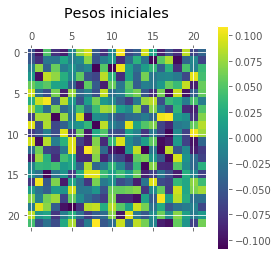

In [19]:
W0 = model.get_weights()[6]
W0 = W0[:484]
W0 = W0.reshape(22,22)
plt.matshow(W0)
plt.colorbar()
plt.title("Pesos iniciales\n")
plt.savefig("PesosIniciales.png" , bbox_inches='tight')

## Entrenando la RED

In [20]:
from keras.callbacks import History 
history = History()

In [21]:
np.random.seed(rs)
set_random_seed(rs)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
np.random.seed(rs)
set_random_seed(rs)
model.fit(X_train, y_train,epochs=70, batch_size=40, verbose=0,callbacks=[history] )

In [23]:
history2 = history.history["loss"].copy()

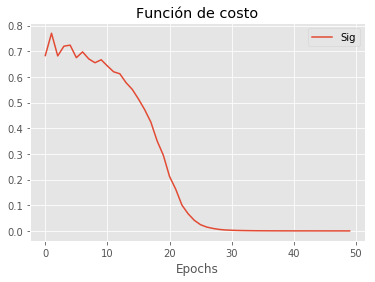

In [24]:
#plt.plot(history1)
plt.plot(history2[:50]) # solo sigmoide
#plt.plot(history3) # solo relu
#plt.plot(history4) # adam mezcla
plt.title("Función de costo")
plt.xlabel("Epochs")
plt.legend(["Sig", "ReLU", "Mix"] )
plt.savefig("función de costoMultiple2.png", dpi=300, quality=100 , bbox_inches='tight')


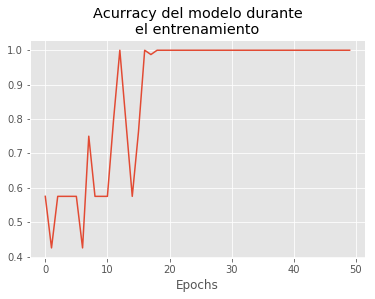

In [25]:
plt.plot(history.history["acc"][:50])
plt.title("Acurracy del modelo durante\nel entrenamiento")
plt.xlabel("Epochs")
plt.savefig("precisión del modelo.png", dpi=300, quality=100 , bbox_inches='tight')

In [26]:
y_train[:5]

99    0
48    1
37    1
96    1
97    0
Name: Clasificador, dtype: int64

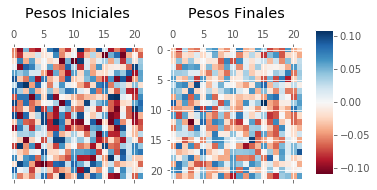

In [27]:
W1 = model.get_weights()[6]
W1 = W1[:484]
W1 = W1.reshape(22,22)

fig , ax = plt.subplots(1,2)
img = ax[0].matshow(W0, cmap = plt.cm.RdBu)
ax[0].title.set_text("Pesos Iniciales\n")

ax[0].set_yticks([])

ax[1].matshow(W1, cmap = plt.cm.RdBu)
ax[1].title.set_text("Pesos Finales\n")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.29, 0.04, 0.5])
fig.colorbar(img, cax=cbar_ax)


plt.savefig("PesosInicialesFinales.png", dpi=300, quality = 100, bbox_inches='tight')
plt.show()


## Generando las predicciones

In [28]:
y_pred = model.predict_classes(X_train) # 
y_pred[:5]

array([[0],
       [1],
       [1],
       [1],
       [0]], dtype=int32)

In [29]:
score = model.evaluate(X_test, y_test,verbose=1)
print(score) #[0.2045641839504242, 0.9523809552192688]

21/21 [==============================] - 0s 3ms/step
[0.20827704668045044, 0.9523809552192688]


## Evaluando el modelo 

In [30]:
# Import the modules from `sklearn.metrics`
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

In [31]:
# Confusion matrix en valores absolutos  solamente el test 
thresholdProb= 0.50
y_pred = np.where(model.predict_proba(X_test)>=thresholdProb,1,0)
ET = pd.DataFrame(confusion_matrix(y_test, y_pred))
ET = ET.sort_index(ascending=False,axis=1)
ET = ET.sort_index(ascending=False,axis=0)
print(ET)
print(precision_score(y_test, y_pred))
print(f1_score(y_test,y_pred))

    1   0
1  10   1
0   0  10
1.0
0.9523809523809523


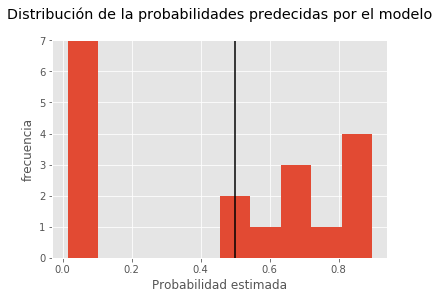

In [32]:
model.predict_proba(X_test)
plt.hist(model.predict_proba(X_test))
plt.title("Distribución de la probabilidades predecidas por el modelo\n")
#plt.suptitle("(Solamente casos y_test = 1)", x=0.5, y= 0.94)
plt.vlines(thresholdProb, 0 ,7)
plt.ylim(0, 7)
plt.xlabel("Probabilidad estimada")
plt.ylabel("frecuencia")

plt.savefig("DistribucionProbEst.png", dpi=300,  bbox_inches='tight')

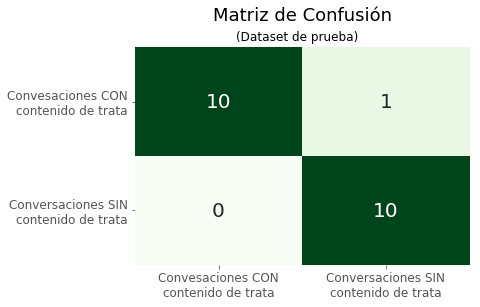

In [33]:
sn.heatmap(ET, annot=True, annot_kws={"size": 20}, cmap = plt.cm.Greens, cbar=False)
plt.title("Matriz de Confusión\n", fontsize= 18)
plt.suptitle("(Dataset de prueba)", x=0.5, y= 0.94)
plt.xticks([0.5,1.5],["Convesaciones CON\ncontenido de trata","Conversaciones SIN\ncontenido de trata"], fontsize = 12)
plt.yticks([0.5,1.5],["Convesaciones CON\ncontenido de trata","Conversaciones SIN\ncontenido de trata"],rotation = 360, fontsize= 12)
plt.savefig("MatrizDeConfusionTEST.png", dpi=300,  bbox_inches='tight')


1.0
0.9887640449438202


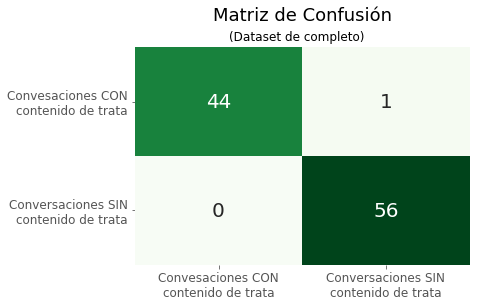

In [34]:
## Considerando todo el data set 
y_hat_prob = np.where(model.predict_proba(X)>thresholdProb,1,0)
TT = pd.DataFrame(confusion_matrix(y, y_hat_prob))
TT = TT.sort_index(ascending=False,axis=1)
TT = TT.sort_index(ascending=False,axis=0)
print(precision_score(y, y_hat_prob))
print(f1_score(y,y_hat_prob))
sn.heatmap(TT, annot=True, annot_kws={"size": 20}, cmap = plt.cm.Greens, cbar=False)
plt.title("Matriz de Confusión\n", fontsize= 18)
plt.suptitle("(Dataset de completo)", x=0.5, y= 0.94)
plt.xticks([0.5,1.5],["Convesaciones CON\ncontenido de trata","Conversaciones SIN\ncontenido de trata"], fontsize = 12)
plt.yticks([0.5,1.5],["Convesaciones CON\ncontenido de trata","Conversaciones SIN\ncontenido de trata"],rotation = 360, fontsize= 12)
plt.savefig("MatrizDeConfusionTOTAL.png", dpi=300, bbox_inches='tight')


# Guardando los pesos

In [35]:
model.save("models/ModeloMi95") 